In [80]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

In [81]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [83]:
# Load the data
file_path = Path("../Resources/flight_data_clean_all.csv")
df = pd.read_csv(file_path, skiprows=0)[:-2]

df.head()

,Unnamed: 0,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,searchDaysBeforeFlight
0,0,2022-09-28,2022-10-05,SFO,ORD,0 days 07:05:00,0,0,0,451.60,1933.0,7
1,1,2022-09-28,2022-10-05,SFO,ORD,0 days 07:52:00,0,0,0,451.60,1933.0,7
2,2,2022-09-28,2022-10-05,SFO,ORD,0 days 08:34:00,0,0,0,451.60,1933.0,7
3,3,2022-09-28,2022-10-05,SFO,PHL,0 days 07:49:00,0,0,0,103.99,2590.0,7
4,4,2022-09-28,2022-10-05,SFO,PHL,0 days 13:19:00,0,0,0,109.59,2590.0,7


In [84]:
#drop first two columns
df = df.iloc[: , 2:]
df.head()

,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,searchDaysBeforeFlight
0,2022-10-05,SFO,ORD,0 days 07:05:00,0,0,0,451.60,1933.0,7
1,2022-10-05,SFO,ORD,0 days 07:52:00,0,0,0,451.60,1933.0,7
2,2022-10-05,SFO,ORD,0 days 08:34:00,0,0,0,451.60,1933.0,7
3,2022-10-05,SFO,PHL,0 days 07:49:00,0,0,0,103.99,2590.0,7
4,2022-10-05,SFO,PHL,0 days 13:19:00,0,0,0,109.59,2590.0,7


In [85]:
#check for null values
df.isna().sum()

flightDate                     0
startingAirport                0
destinationAirport             0
travelDuration                 0
isBasicEconomy                 0
isRefundable                   0
isNonStop                      0
totalFare                      0
totalTravelDistance       116321
searchDaysBeforeFlight         0
dtype: int64

In [86]:
#drop null values. still have over 1.5 million rows of data.
df = df.dropna()
df.isna().sum()

flightDate                0
startingAirport           0
destinationAirport        0
travelDuration            0
isBasicEconomy            0
isRefundable              0
isNonStop                 0
totalFare                 0
totalTravelDistance       0
searchDaysBeforeFlight    0
dtype: int64

In [87]:
# check df datatypes
df.dtypes

flightDate                 object
startingAirport            object
destinationAirport         object
travelDuration             object
isBasicEconomy              int64
isRefundable                int64
isNonStop                   int64
totalFare                 float64
totalTravelDistance       float64
searchDaysBeforeFlight      int64
dtype: object

In [88]:
# start new df and encode startingAirport and endingAirport
le = LabelEncoder()
df2 = df.copy()
df2['startingAirport'] = le.fit_transform(df2['startingAirport'])
df2['destinationAirport'] = le.fit_transform(df2['destinationAirport'])

In [89]:
#convert travelDuration to minutes
df2['travelDurationDays'] = pd.to_numeric(df2['travelDuration'].str.slice(0,1))
df2['travelDurationHours'] = pd.to_numeric(df2['travelDuration'].str.slice(7,9))
df2['travelDurationMinutes'] = pd.to_numeric(df2['travelDuration'].str.slice(10,12))
df2['travelDurationFinal'] = ((df2['travelDurationDays']*1440)+(df2['travelDurationHours']*60)+(df2['travelDurationMinutes']))
df2 = df2.drop(columns=['travelDurationDays','travelDurationHours','travelDurationMinutes','travelDuration'])
df2.head()

,flightDate,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,searchDaysBeforeFlight,travelDurationFinal
0,2022-10-05,15,13,0,0,0,451.60,1933.0,7,425
1,2022-10-05,15,13,0,0,0,451.60,1933.0,7,472
2,2022-10-05,15,13,0,0,0,451.60,1933.0,7,514
3,2022-10-05,15,14,0,0,0,103.99,2590.0,7,469
4,2022-10-05,15,14,0,0,0,109.59,2590.0,7,799


In [90]:
# convert flight date to number format
df2['flightDate'] = pd.to_datetime(df['flightDate']).astype('int64')/ 10**9
df2.dtypes

flightDate                float64
startingAirport             int32
destinationAirport          int32
isBasicEconomy              int64
isRefundable                int64
isNonStop                   int64
totalFare                 float64
totalTravelDistance       float64
searchDaysBeforeFlight      int64
travelDurationFinal         int64
dtype: object

In [124]:
# Creating the scaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()
X = pd.DataFrame(data_scaler.fit_transform(df2.drop(["totalFare"],axis = 1),),columns=['flightDate','startingAirport','destinationAirport',
                                                                                      'isBasicEconomy','isRefundable','isNonStop','totalTravelDistance',
                                                                                      'searchDaysBeforeFlight','travelDurationFinal'])
y = df2["totalFare"]

In [125]:
X.head()

,flightDate,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,totalTravelDistance,searchDaysBeforeFlight,travelDurationFinal
0,-1.419998,1.59102,1.164061,-0.633786,-0.002212,-0.589664,0.311568,-1.287976,-0.030198
1,-1.419998,1.59102,1.164061,-0.633786,-0.002212,-0.589664,0.311568,-1.287976,0.174699
2,-1.419998,1.59102,1.164061,-0.633786,-0.002212,-0.589664,0.311568,-1.287976,0.357799
3,-1.419998,1.59102,1.376512,-0.633786,-0.002212,-0.589664,1.050252,-1.287976,0.161620
4,-1.419998,1.59102,1.376512,-0.633786,-0.002212,-0.589664,1.050252,-1.287976,1.600261


In [126]:
# Create our features
#X = df2.copy()
#X = X.drop("totalFare", axis=1)

# Create our target
#y = df2["totalFare"]

In [127]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)
X_train.shape 

(1226787, 9)

In [128]:
# fit a linear regression model
regr = LinearRegression()
regr.fit(X_train, y_train) 

LinearRegression()

In [129]:
#predict flight costs
y_prediction = regr.predict(X_test)
y_prediction

array([193.13987793, 303.82128748, 337.4056246 , ...,  90.72735578,
       408.1134495 , 163.03407059])

In [130]:
# evaluate linear regression model
score = r2_score(y_test,y_prediction)
print('r2 score: ',score)
print('mean_sqrd_error: ',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of: ',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 score:  0.4250553525214895
mean_sqrd_error:  21500.144505885364
root_mean_squared error of:  146.62927574630302


In [123]:
regr.feature_importances_

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [131]:
#initialize random forest regressor model
X_train, y_train = make_regression(n_features=9)
forestRegr = RandomForestRegressor(max_depth=None, random_state=0)

In [132]:
#fit random forest regessor data
forestRegr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [133]:
#run random forest regressor model
forestPredict = forestRegr.predict(X_test)
forestPredict

array([-111.58592722,  113.88523658, -188.58500013, ..., -154.80900785,
         86.22779986, -128.77174266])

In [134]:
#evaluate random forest regressor model
forestScore = r2_score(y_test, forestPredict)
print('r2 score: ',forestScore)
print('mean_sqrd_error: ',mean_squared_error(y_test,forestPredict))
print('root_mean_squared error of: ',np.sqrt(mean_squared_error(y_test,forestPredict)))

r2 score:  -3.615607094254454
mean_sqrd_error:  172601.34509308485
root_mean_squared error of:  415.453180386292


In [121]:
forestRegr.feature_importances_

array([0.23576096, 0.21515217, 0.02450596, 0.02241565, 0.23615077,
       0.04968442, 0.15185482, 0.03340164, 0.03107362])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

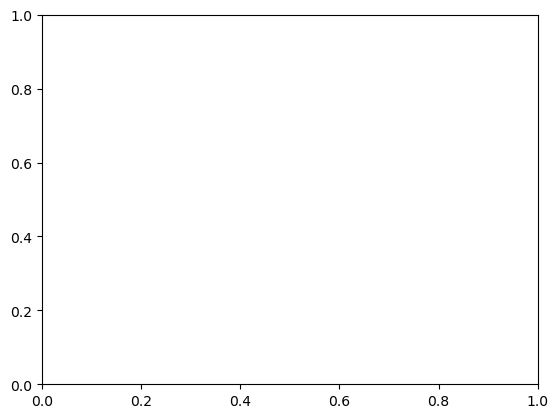

In [52]:
plt.barh(forestRegr, forestRegr.feature_importances_)